### Trying GPy

In [0]:
# ! pip install gpy

    100% |████████████████████████████████| 880kB 19.6MB/s 
    100% |████████████████████████████████| 71kB 17.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/97/82/1d/32a361e1ff2b4d9129a60343831dd99cdc74440e2db1c55264
  Stored in directory: /root/.cache/pip/wheels/a9/fc/74/3bbd263c43ed98d67343df24cebf0a0ee34afee40d769fda9c
Successfully built gpy paramz


In [0]:
# import plotly

In [0]:
import numpy as np
# import pymc as pm
import GPy 
import matplotlib.pyplot as plt
GPy.plotting.change_plotting_library('plotly')

In [0]:
# Define dataset 
N = 100
k1 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,10,10,0.1,0.1]), ARD=True)
k2 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,0.1,10,0.1,10]), ARD=True)
k3 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[0.1,0.1,10,10,10]), ARD=True)
X = np.random.normal(0, 1, (N, 5))
A = np.random.multivariate_normal(np.zeros(N), k1.K(X), 10).T
B = np.random.multivariate_normal(np.zeros(N), k2.K(X), 10).T
C = np.random.multivariate_normal(np.zeros(N), k3.K(X), 10).T

Y = np.vstack((A,B,C))
labels = np.hstack((np.zeros(A.shape[0]), np.ones(B.shape[0]), np.ones(C.shape[0])*2))

input_dim = 2 # How many latent dimensions to use
kernel = GPy.kern.RBF(input_dim, 1, ARD=True) 


In [0]:
A.shape, B.shape, C.shape, Y.shape

((100, 10), (100, 10), (100, 10), (300, 10))

In [0]:
from sklearn.decomposition import PCA

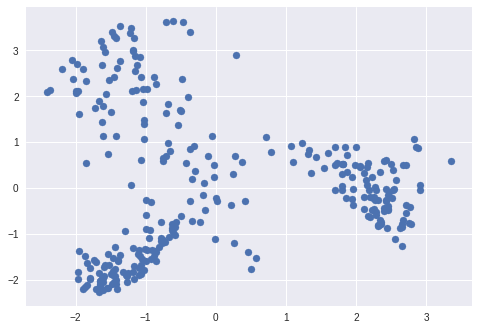

In [0]:
pca= PCA(n_components=2)
y_test = pca.fit_transform(Y)

plt.scatter(y_test[:,0], y_test[:,1])

In [0]:
Q = input_dim
m_gplvm = GPy.models.GPLVM(Y, Q, kernel=GPy.kern.RBF(Q))
m_gplvm.kern.lengthscale = .2
m_gplvm.kern.variance = 1
m_gplvm.likelihood.variance = 1.
#m2.likelihood.variance.fix(.1)
m_gplvm

GPLVM.,value,constraints,priors
latent_mean,"(300, 2)",,
rbf.variance,1.0,+ve,
rbf.lengthscale,0.2,+ve,
Gaussian_noise.variance,1.0,+ve,


In [0]:
m_gplvm.optimize(messages=1, max_iters=5e4)

In [0]:
figure = GPy.plotting.plotting_library().figure(1, 2, 
                        shared_yaxes=True,
                        shared_xaxes=True,
                        subplot_titles=('Latent Space', 
                                        'Magnification',
                                        )
                            )


canvas = m_gplvm.plot_latent(labels=labels, figure=figure, col=(1), legend=False)
canvas = m_gplvm.plot_magnification(labels=labels, figure=figure, col=(2), legend=False)

GPy.plotting.show(canvas, filename='wishart_metric_notebook')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]



/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




ValueError: ignored

### Trying PyMC implementation

In [0]:
import sys

import pymc3 as pm
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

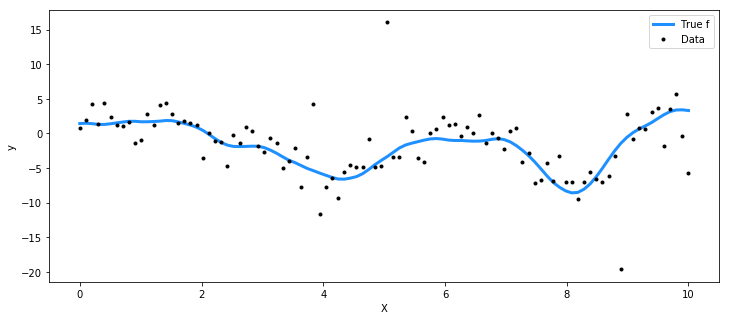

In [0]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

In [0]:
# with pm.Model() as model:
#     ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
#     η = pm.HalfCauchy("η", beta=5)

#     cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     gp = pm.gp.Latent(cov_func=cov)

#     f = gp.prior("f", X=X)
    
#     σ = pm.HalfCauchy("σ", beta=5)
#     ν = pm.Gamma("ν", alpha=2, beta=0.1)
#     y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)
#     print("here")
#     trace = pm.sample(10)

In [0]:
print(X.shape)

(100, 1)


In [0]:
with pm.Model() as model:
    X_ = pm.Normal("X", mu = X.mean(), sd = X.std(), shape = 100, observed= True)
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)
    
    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)
    print("here")
    trace = pm.sample(10, tune = 10)

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


here


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, σ, f_rotated_, η, ℓ]
Sampling 2 chains: 100%|██████████| 40/40 [00:17<00:00,  2.26draws/s]
/home/arnav/miniconda3/lib/python3.6/site-packages/pymc3/sampling.py:466: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [0]:
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[X_], samples=1000, size = 1000)


print(pred_samples['X'].shape)
dat_mean, dat_std = pred_samples['X'].mean(),pred_samples['X'].std()
(dat_mean,dat_std) ,(X.mean(), X.std())

100%|██████████| 1000/1000 [00:00<00:00, 2006.94it/s]


(1000, 1000)


((5.002411227111469, 2.914302863759382), (5.0, 2.9157646512850626))

^^ the above shows that we can resample the input

how to do it given the params?

write the marginal of X in terms of Y and set Y=observed and try if time

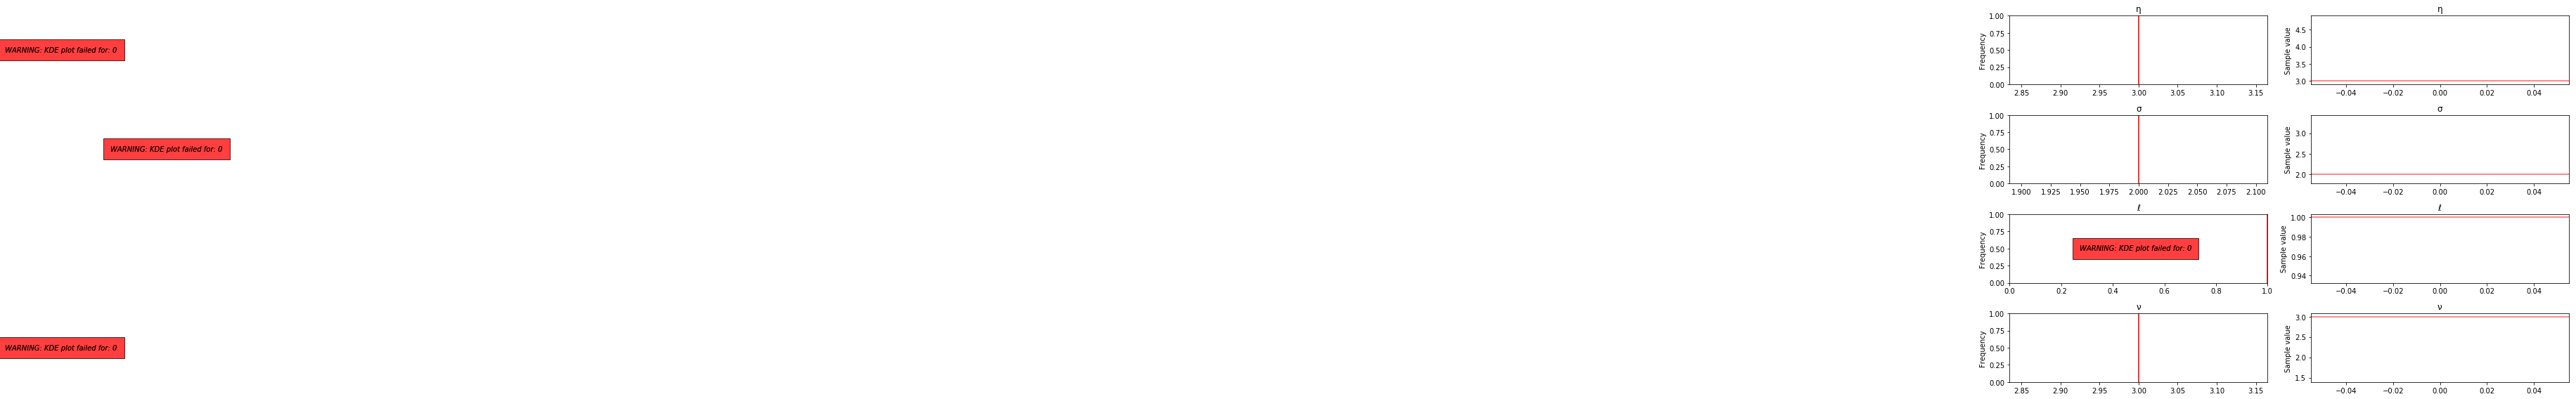

In [0]:
pm.traceplot(trace, lines={"η": η_true, "σ": σ_true, "ℓ": ℓ_true, "ν": ν_true}, varnames=["η", "σ", "ℓ", "ν"]);

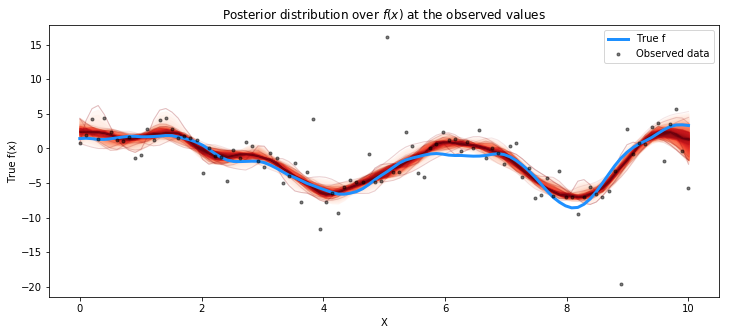

In [0]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [0]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 15, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)



100%|██████████| 1000/1000 [01:19<00:00, 12.57it/s]


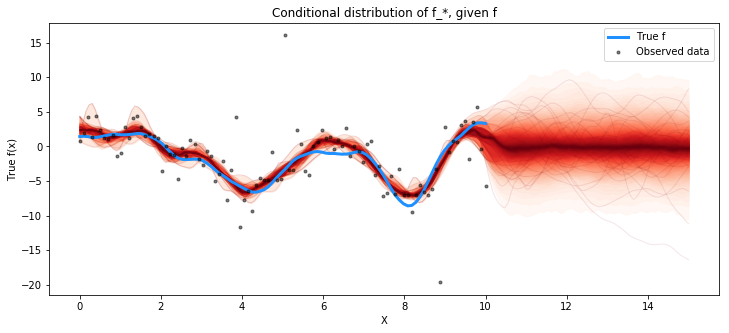

In [0]:

# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();

{'f_pred': array([[ 3.40192797,  3.45024769,  3.4136014 , ...,  2.39702219,
          3.29866343,  4.04188717],
        [ 2.88494901,  2.52414298,  2.26525973, ..., -4.3606087 ,
         -4.37894503, -4.42346404],
        [ 2.46457777,  2.46536618,  2.47215747, ...,  0.40306602,
          1.17408017,  1.78609591],
        ...,
        [ 4.22996617,  3.79557982,  3.35966153, ..., -2.18671487,
         -2.45004651, -2.89640482],
        [ 2.8789624 ,  2.60649128,  2.48169832, ..., -2.90329394,
         -2.74128724, -2.72869213],
        [ 3.25770365,  3.09712956,  3.07255078, ...,  0.32208833,
          0.4420627 ,  0.48311644]])}

### Trying GPflow

In [0]:
! pip install gpflow

    100% |████████████████████████████████| 256kB 20.7MB/s 


In [0]:
import gpflow as gp

In [0]:
import gpflow
from gpflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
np.random.seed(42)
gpflow.settings.numerics.quadrature = 'error'  # throw error if quadrature is used for kernel expectations

In [0]:
data = np.loadtxt('data/DataTrn.txt')
labels_ = np.loadtxt("data/DataTrnLbls.txt")
Y = data
# labels = data['labels']

# print('Number of points x Number of dimensions', Y.shape)


OSError: ignored

In [0]:
Q = 5
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]

fHmmm = False
if(fHmmm):
    k = (kernels.RBF(3, ARD=True, active_dims=slice(0,3)) +
         kernels.Linear(2, ARD=False, active_dims=slice(3,5)))
else:
    k = (kernels.RBF(3, ARD=True, active_dims=[0,1,2]) +
         kernels.Linear(2, ARD=False, active_dims=[3, 4]))

m = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

opt = gpflow.train.ScipyOptimizer()
m.compile()
opt.minimize(m, maxiter=gpflow.test_util.notebook_niter(10000))

/home/arnav/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -5535.574334
  Number of iterations: 1663
  Number of functions evaluations: 1767


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -5535.574334
  Number of iterations: 1663
  Number of functions evaluations: 1767


In [0]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/kern/kernels/0/lengthscales,Parameter,None,+ve,True,"(3,)",True,"[5.717519832562978, 69.94117024188954, 1.61438..."
BayesianGPLVM/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,21.638272060813293
BayesianGPLVM/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,0.027213507953804825


In [0]:
kern = m.kern.kernels[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(sens)

[0.81358627 0.06650869 2.88141104]


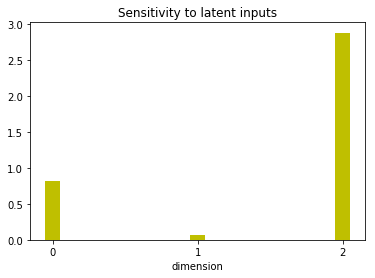

In [0]:
fig, ax = plt.subplots()
dims = np.arange(len(sens))
ax.bar(dims, sens, 0.1, color='y')
ax.set_xticks(dims)
ax.set_xlabel('dimension')
ax.set_title('Sensitivity to latent inputs');

In [0]:
dim1, dim2 = sens.argsort()[::-1][:2]  # the two dimensions with highest sensitivity

In [0]:
labels = [l.argmax() for l in labels_]

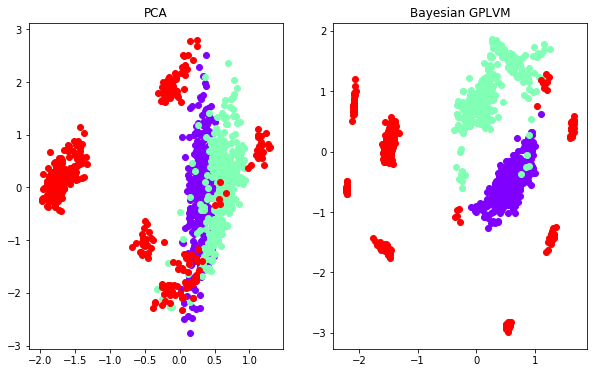

In [0]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i, 0], XPCAplot[labels==i, 1], color=c, label=i)
    ax[0].set_title('PCA')
    ax[1].scatter(GPLVM_X_mean[labels==i, dim1], GPLVM_X_mean[labels==i, dim2], color=c, label=i)
    ax[1].set_title('Bayesian GPLVM')

In [0]:
# reconstruction error based only on the mean predictions
# mean Y | X
((m.predict_y(GPLVM_X_mean[:,:])[0] - Y[:,:])**2).sum(axis = 1).mean()

0.01900653752975054

In [0]:
# f | x
m.predict_f(GPLVM_X_mean[0].reshape(1,5))

(array([[0.31762794, 0.15113056, 0.64923904, 0.21047601, 0.72054584,
         0.24760859, 0.66996562, 0.20628934, 0.74849885, 0.24887449,
         0.59426458, 0.18852404]]),
 array([[5.46845812e-05, 5.46845812e-05, 5.46845812e-05, 5.46845812e-05,
         5.46845812e-05, 5.46845812e-05, 5.46845812e-05, 5.46845812e-05,
         5.46845812e-05, 5.46845812e-05, 5.46845812e-05, 5.46845812e-05]]))

In [0]:
##log lokelihood of Y_new | x_new
m.predict_density(GPLVM_X_mean[1].reshape(1,5), Y[0].reshape(1,12)).sum()

-570.6220406957914

In [0]:
GPLVM_X_mean[0]

array([-1.14369628, -0.01698357,  0.37374261,  0.02351539, -0.78905761])

In [0]:
## find X_new | Y_new ??


### same on MNIST

In [0]:
! pip install torch torchvision

In [3]:
! pip install gpflow

    100% |████████████████████████████████| 256kB 7.3MB/s 


In [0]:
import gpflow
from gpflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
np.random.seed(42)
gpflow.settings.numerics.quadrature = 'error' 
import torch, torchvision
import torchvision.transforms as transforms
root = './data'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [0]:
from tqdm import tqdm_notebook as tqdm

In [5]:
MNIST_train = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
MNIST_test  = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27047701.58it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 453402.37it/s]
  1%|          | 16384/1648877 [00:00<00:11, 145788.25it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7220392.37it/s]                            
8192it [00:00, 180956.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


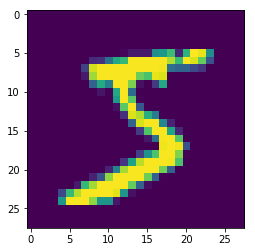

In [6]:
plt.imshow(MNIST_train[0][0].reshape(28,28))

(<matplotlib.image.AxesImage at 0x7f40567f2908>, 7)

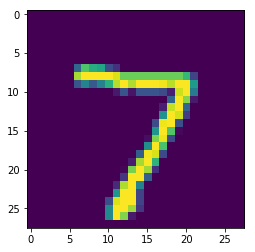

In [7]:
plt.imshow(MNIST_test[0][0].reshape(28,28)), MNIST_test[0][1]

In [8]:
 MNIST_train[0][1]

5

In [0]:
x = []
labels = []
for t, l in MNIST_train:
    x.append(t.numpy().flatten())
    labels.append(l)

In [0]:
x = np.array(x)
labels = np.array(labels)

In [70]:
x.shape

(60000, 784)

In [187]:
# x_3 = x[np.where(labels <= 1)]
# l_3 = labels[np.where(labels <= 1)]

x_5 = None
l_5 = []
samples = 20
for n in range(5):
    d = x[np.where(labels == n)]
    idxs = np.random.choice(range(d.shape[0]), samples)
#     print(d.shape)
#     print(d[0])
#     break
    print(d[idxs].shape)
    if x_5 is None:
        x_5 = d[idxs]
    else:
        x_5 = np.vstack((x_5, d[idxs]))
    l_5 = np.hstack((l_5,n* np.ones(samples)))

(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)


In [0]:
# l_5[l_5==1].shape
x_5 = np.array(x_5)

In [189]:
Y = x_5.astype(np.float64)

Y.shape  , #l_5[l_5 == i].shape, i

((100, 784),)

In [0]:
del x

In [0]:
## making gpflow kernels
# k_test = kernels.RBF(5,ARD=True, active_dims=[0,1,2, 3, 4])

In [0]:
# k_test.compute_K(np.ones((5, 1)),2* np.ones((5, 1)))    

In [0]:
# Q = 50
# X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
# Z = np.random.permutation(X_mean.copy())[:20]
# X_mean.shape, Z.shape

In [191]:
Q = 5
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA # other initializations?
Z = np.random.permutation(X_mean.copy())[:M]
kernel_dim = 5

fHmmm = True
if(fHmmm):
    k = kernels.RBF(kernel_dim, ARD=True, active_dims=slice(0,kernel_dim)) #+
         #kernels.Linear(5, ARD=False, active_dims=slice(5,10)))
else:
    k = (kernels.RBF(5, ARD=True, active_dims=[0, 1, 2, 3, 4]) +
         kernels.Linear(2, ARD=False, active_dims=[5, 6]))

m = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

opt = gpflow.train.ScipyOptimizer()
# opt = gpflow.train.AdamOptimizer()
m.compile()
opt.minimize(m, maxiter=gpflow.test_util.notebook_niter(500))
print("done")


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -9588.515662
  Number of iterations: 500
  Number of functions evaluations: 558


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -9588.515662
  Number of iterations: 500
  Number of functions evaluations: 558


done


In [20]:
m

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/X_mean,Parameter,None,(none),True,"(250, 5)",True,"[[0.9124867585329028, 0.22397278396796602, -0...."
BayesianGPLVM/X_var,Parameter,None,+ve,True,"(250, 5)",True,"[[0.00459812196179218, 0.0033043951154245986, ..."
BayesianGPLVM/feature/Z,Parameter,None,(none),True,"(20, 5)",True,"[[-1.1645445276987754, -0.5671295518460037, -2..."
BayesianGPLVM/kern/lengthscales,Parameter,None,+ve,True,"(5,)",True,"[7.778473468886734, 4.507898992462784, 6.03707..."
BayesianGPLVM/kern/variance,Parameter,None,+ve,True,(),True,0.3827155007010727
BayesianGPLVM/likelihood/variance,Parameter,None,+ve,True,(),True,0.03078660519425074


In [21]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/kern/lengthscales,Parameter,None,+ve,True,"(5,)",True,"[7.778473468886734, 4.507898992462784, 6.03707..."
BayesianGPLVM/kern/variance,Parameter,None,+ve,True,(),True,0.3827155007010727


In [22]:
kern = m.kern#.kernels[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(sens)

[0.07953232 0.13723467 0.10247339 0.17725701 0.22660198]


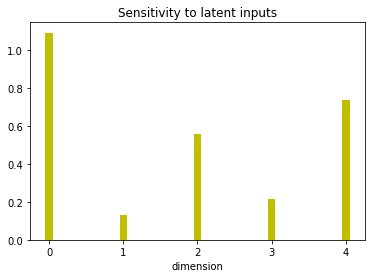

In [192]:
fig, ax = plt.subplots()
dims = np.arange(len(sens))
ax.bar(dims, sens, 0.1, color='y')
ax.set_xticks(dims)
ax.set_xlabel('dimension')
ax.set_title('Sensitivity to latent inputs');
plt.savefig('mnist_1l_sens.png')

In [0]:
dim1, dim2 = sens.argsort()[::-1][:2] 

In [0]:
(l_5==i).shape

(250,)

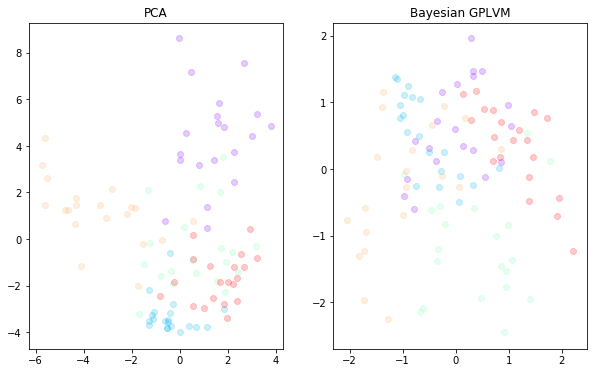

In [286]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(l_5))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[l_5==i, 0], XPCAplot[l_5==i, 1], color=c, label=i, alpha = 0.2)
    ax[0].set_title('PCA')
    ax[1].scatter(GPLVM_X_mean[l_5==i, dim1], GPLVM_X_mean[l_5==i, dim2], color=c, label=i, alpha = 0.2)
    ax[1].set_title('Bayesian GPLVM')
    f.savefig("mnist_1l_pca_rep.png")

17


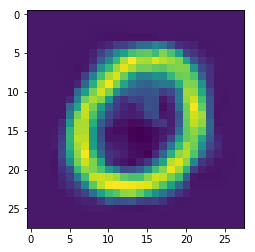

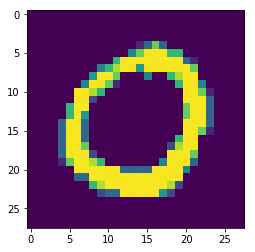

In [81]:
def reconstruct(Q, i):
    print(i)
    y = m.predict_y(GPLVM_X_mean[i].reshape(1,Q))[0]  #returns (mean, vars)

    plt.imshow(y.reshape(28,28))
#     plt.savefig("reconstruction"+str(i) + ".png")
    plt.figure()
    plt.imshow(Y[i].reshape(28,28))
#     plt.savefig("actual" +str(i) + ".png")

reconstruct(Q, i=np.random.randint(0,100))

In [0]:
(GPLVM_X_mean[i].reshape(1,Q)[0] + np.random.randn(1,Q)).shape

(1, 5)

### Deep Model  Implementation

In [0]:
class DeepGPLVMv0:
    def __init__(self,kernel_dim = 5, n_layers=2, inducing_pts=20, latent_dims=[100,20], max_iters=10):
        self.kernel = kernels.RBF(kernel_dim, ARD=True, active_dims=slice(0,kernel_dim))
        self.latent_dims = latent_dims
        self.inducing_pts = inducing_pts
        self.n_layers = n_layers
        self.max_iters = max_iters
        
    def train(self, Y):
        self.models = []
        M = self.inducing_pts
        N = Y.shape[0]
        
        for i in range(self.n_layers):
            Q = self.latent_dims[i]
            X_mean = gpflow.models.PCA_reduce(Y, Q)
            Z = np.random.permutation(X_mean.copy())[:M]
            
            
            m1 = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=self.kernel, M=M, Z=Z)
            m1.likelihood.variance = 0.01
            m1.compile()
            opt = gpflow.train.ScipyOptimizer()
            opt.minimize(m1, maxiter=gpflow.test_util.notebook_niter(self.max_iters))
            self.models.append(m1) 
            Y = m1.X_mean.read_value()

            self.means = Y.copy()

    
    def reconstruct(self, idx):
        x_mean = self.means[idx].reshape(1, self.latent_dims[-1])
        for model in reversed(self.models):
            x_recon = model.predict_y(x_mean)[0]
            x_mean = x_recon
        return x_recon
    def predict_likelihoods(self, X, Y):
        pass

In [0]:
class DeepGPLVM:
    def __init__(self,kernel_dims = [5, 5], n_layers=2, inducing_pts=[20, 20], latent_dims=[100,20], max_iters=10):
        self.kernel_dims = kernel_dims
        self.latent_dims = latent_dims
        self.inducing_pts = inducing_pts
        self.n_layers = n_layers
        self.max_iters = max_iters
        
    def train(self, Y):
        self.models = []
        N = Y.shape[0]
        
        for i in range(self.n_layers):
            M = self.inducing_pts[i]
            kernel = kernels.RBF(self.kernel_dims[i], ARD=True, active_dims=slice(0,self.kernel_dims[i]))
            Q = self.latent_dims[i]
            X_mean = gpflow.models.PCA_reduce(Y, Q)
            Z = np.random.permutation(X_mean.copy())[:M]
            
            
            m1 = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=kernel, M=M, Z=Z)
            m1.likelihood.variance = 0.01
            m1.compile()
            opt = gpflow.train.ScipyOptimizer()
            opt.minimize(m1, maxiter=gpflow.test_util.notebook_niter(self.max_iters))
            self.models.append(m1) 
            Y = m1.X_mean.read_value()

            self.means = Y.copy()

    
    def reconstruct(self, idx):
        x_mean = self.means[idx].reshape(1, self.latent_dims[-1])
        for model in reversed(self.models):
            x_recon = model.predict_y(x_mean)[0]
            x_mean = x_recon
        return x_recon
    
    def reconstruct_from_input(self, test):
        for model in reversed(self.models):
            x_recon = model.predict_y(test)[0]
            test = x_recon
        return x_recon
    
    def reconstructon_error(self, Y):
        total_err = 0
        for y in Y:
            recon  = self.reconstruct_from_input(y.reshape(1, Y.shape[1]))
            error = np.sqrt(((Y - recon)**2).sum()/Y.shape[1])
            total_err += error
            
        return total_err / Y.shape[0]
    
    def get_sensitivities(self, plot = False):
        sensitivities = []
        for model in reversed(self.models):
            kern = model.kern
            sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
            print(sens)
            sensitivities.append(sens)
            if plot == True:
                plt.figure()
                plt.bar(dims, sens, 0.2, color='y')
                plt.xticks(dims)
                plt.xlabel('dimension')
                plt.title('Sensitivity to latent inputs');
                plt.bar(np.arange(len(sens)), sens)
        return sensitivities
    
    def predict_likelihoods(self, X, Y):
        pass
    

In [200]:
dgp = DeepGPLVM(kernel_dims = [10,5], n_layers = 2, max_iters=300, latent_dims = [20, 5], inducing_pts=[20,20])
Y = x_5.astype(np.float64)
dgp.train(Y)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -12017.313656
  Number of iterations: 300
  Number of functions evaluations: 360


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -12017.313656
  Number of iterations: 300
  Number of functions evaluations: 360


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1786.611738
  Number of iterations: 300
  Number of functions evaluations: 326


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1786.611738
  Number of iterations: 300
  Number of functions evaluations: 326


[0.1476206  0.60075098 0.22371683 0.9156594  0.46505375]
[0.04653562 0.05395817 0.06020102 0.05785901 0.04311279 0.04554821
 0.13430964 0.04170134 0.03483984 0.0628714 ]


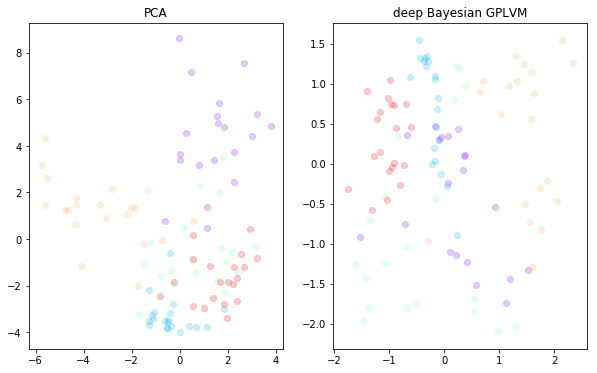

In [205]:
sens = dgp.get_sensitivities()[0]
dim1, dim2 = sens.argsort()[::-1][:2] 
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
dgp_mean = dgp.means

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(l_5))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[l_5==i, 0], XPCAplot[l_5==i, 1], color=c, label=i, alpha = 0.2)
    ax[0].set_title('PCA')
    ax[1].scatter(dgp_mean[l_5==i, dim1], dgp_mean[l_5==i, dim2], color=c, label=i, alpha = 0.2)
    ax[1].set_title('deep Bayesian GPLVM')
    f.savefig("mnist_2l_pca_rep.png")

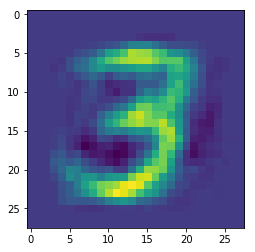

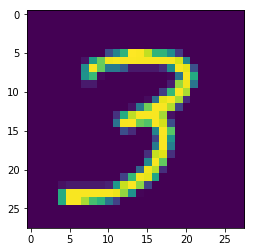

In [113]:
# GPLVM_X_mean = m.X_mean.read_value()
# recon = dgp.reconstruct(GPLVM_X_mean[6].reshape(1,Q))
i = np.random.randint(0,100)
recon = dgp.reconstruct(i)
plt.figure()
plt.imshow(recon.reshape(28,28))
plt.savefig("test1.png")
plt.figure()
plt.imshow(Y[i].reshape(28,28))

In [0]:
# from google.colab import files
# files.download("test.png")

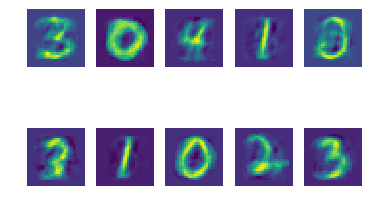

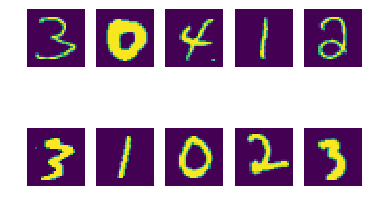

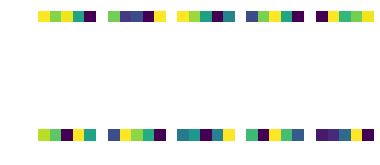

In [216]:
idxs = np.random.randint(0, Y.shape[0],10)#np.random.permutation(dgp.means)[:10]

# random_sample = dgp.means[idxs]

plt.figure()
for i, idx in enumerate(idxs,1):
#     rec= m.reconstruct(idx)
    rec = dgp.reconstruct(idx)
    plt.subplot(2,5,i)
#     print(rec.shape)
    plt.imshow(rec.flatten().reshape(28, 28))
    plt.axis("off")
plt.savefig("mnist_2l_recon.png")

plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(y.flatten().reshape(28, 28))

plt.savefig("mnist_orig.png")
plt.figure()
for i, idx in enumerate(idxs, 1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(dgp.means[idx].flatten().reshape(1,5))
plt.savefig("mnist_repn_2l.png")

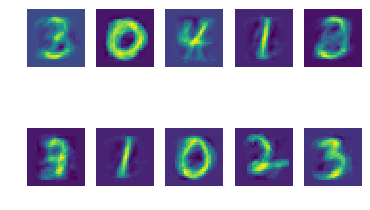

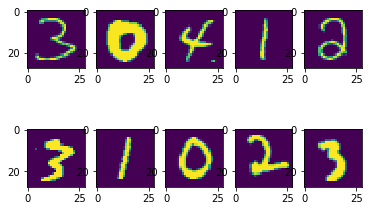

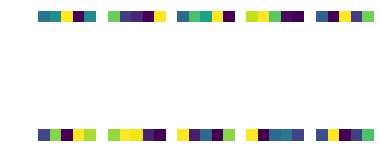

In [217]:
plt.figure()
for i, idx in enumerate(idxs,1):
    rec= m.predict_y(GPLVM_X_mean[idx].reshape(1,5))[0]
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(rec.flatten().reshape(28, 28))
plt.savefig("mnist_1l_recon.png")
plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.imshow(y.flatten().reshape(28, 28))

    
plt.figure()
for i, idx in enumerate(idxs, 1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(GPLVM_X_mean[idx].flatten().reshape(1,5))
plt.savefig("mnist_repn_1l.png")

In [0]:
dgp.reconstructon_error(Y)

4.432431670278695

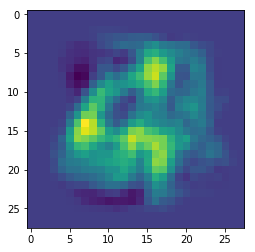

In [92]:
test = np.random.randn(dgp.latent_dims[-1]).reshape(1, dgp.latent_dims[-1])
# for model in reversed(dgp.models):
#     x_recon = model.predict_y(test)[0]
#     x_mean = x_recon
recon = dgp.reconstruct_from_input(test)
plt.imshow(recon.flatten().reshape(28,28))

[0.1476206  0.60075098 0.22371683 0.9156594  0.46505375]


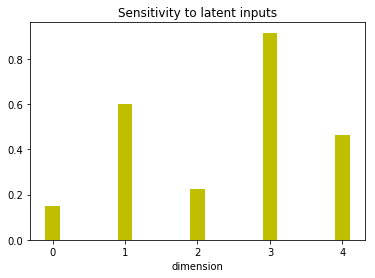

In [218]:
kern = dgp.models[1].kern#.kernels[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(sens)
fig, ax = plt.subplots()
dims = np.arange(len(sens))
ax.bar(dims, sens, 0.2, color='y')
ax.set_xticks(dims)
ax.set_xlabel('dimension')
ax.set_title('Sensitivity to latent inputs');
plt.savefig("mnist_2l_latent_sens.png")

In [0]:
# dgp.get_sensitivities(plot = True)

In [0]:
layers = [1, 2]
dim_list = [[[5], [10], [20]], [[10, 5], [10, 10], [20, 10]]]
inducing_pts = [[10, 20, 40], [[20, 20], [20, 10], [10, 10]]]


# frey faces

In [290]:
! wget "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat" > frey.mat

--2019-04-26 08:32:51--  http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat
Resolving www.cs.nyu.edu (www.cs.nyu.edu)... 128.122.49.30
Connecting to www.cs.nyu.edu (www.cs.nyu.edu)|128.122.49.30|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.nyu.edu/~roweis/data/frey_rawface.mat [following]
--2019-04-26 08:32:51--  https://cs.nyu.edu/~roweis/data/frey_rawface.mat
Resolving cs.nyu.edu (cs.nyu.edu)... 128.122.49.30
Connecting to cs.nyu.edu (cs.nyu.edu)|128.122.49.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100584 (1.0M) [text/plain]
Saving to: ‘frey_rawface.mat’

frey_rawface.mat    100%[===================>]   1.05M  --.-KB/s    in 0.1s    

2019-04-26 08:32:52 (9.97 MB/s) - ‘frey_rawface.mat’ saved [1100584/1100584]



In [0]:
! ls

data  frey.mat	frey_rawface.mat  sample_data  test1.png


In [291]:
from scipy import io as spio
data = spio.loadmat("frey_rawface.mat")
faces = data['ff'].T
faces = faces.astype(np.float32)/255
faces.shape

(1965, 560)

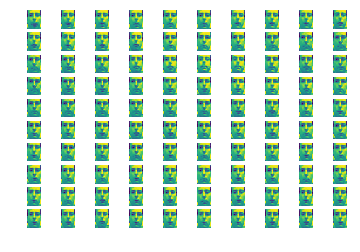

In [292]:
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.axis("off")
    plt.imshow(faces[i, :].reshape(28, 20))


In [0]:
idxs = np.random.randint(0, faces.shape[0], 200)
subset = faces[idxs, :]

In [294]:
dgp_f = DeepGPLVM(kernel_dims = [5, 3], n_layers = 2, max_iters=50, latent_dims = [10, 3], inducing_pts=[20, 20])
Y = subset.astype(np.float64)
dgp_f.train(Y)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -128926.151897
  Number of iterations: 50
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -128926.151897
  Number of iterations: 50
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3382.210749
  Number of iterations: 50
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3382.210749
  Number of iterations: 50
  Number of functions evaluations: 57


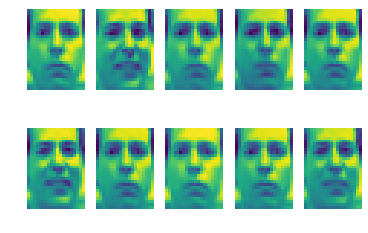

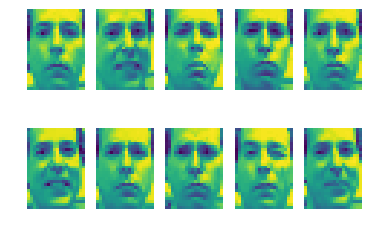

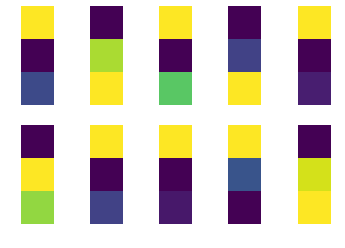

In [296]:
idxs = np.random.randint(0, Y.shape[0],10)#np.random.permutation(dgp.means)[:10]

# random_sample = dgp.means[idxs]

plt.figure()
for i, idx in enumerate(idxs,1):
#     rec= m.reconstruct(idx)
    rec = dgp_f.reconstruct(idx)
    plt.subplot(2,5,i)
#     print(rec.shape)
    plt.axis("off")
    plt.imshow(rec.flatten().reshape(28, 20))
plt.savefig("frey_recon_2l.png")

plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(y.flatten().reshape(28, 20))
plt.savefig("frey_orig_2l.png")

    
plt.figure()
for i, idx in enumerate(idxs, 1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(dgp_f.means[idx].flatten().reshape(3, 1))
plt.savefig("frey_2l_rep.png")

In [0]:
dgp_f.reconstructon_error(Y)

1.6707204412241508

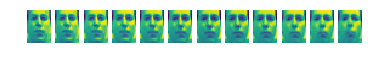

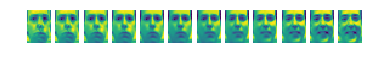

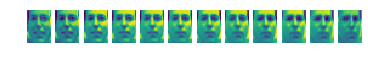

In [297]:
steps = np.arange(-3, 3, 0.5)
for i in range(3):
    plt.figure()
    for j, s in enumerate(steps):
        
        test = np.zeros((1,3))
        test[0][i] += s
        recon = dgp_f.reconstruct_from_input(test)
        plt.subplot(1, 12, j + 1 )
        plt.axis("off")
        plt.imshow(recon.reshape(28, 20))
        plt.savefig("frey_feature_{0}_trend_2l.png".format(i))

In [300]:
dgp_f3 = DeepGPLVM(kernel_dims = [5, 5, 3], n_layers = 3, max_iters=50, latent_dims = [10, 5, 3], inducing_pts=[20, 20, 20])
Y = subset.astype(np.float64)
dgp_f3.train(Y)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -128784.037425
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -128784.037425
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 2589.782168
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 2589.782168
  Number of iterations: 50
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1690.256770
  Number of iterations: 50
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1690.256770
  Number of iterations: 50
  Number of functions evaluations: 57


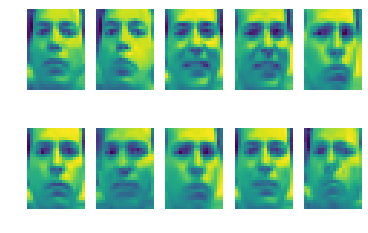

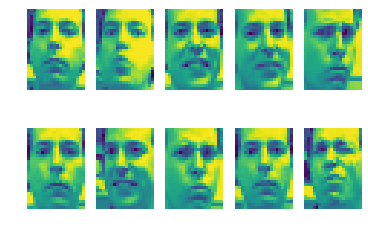

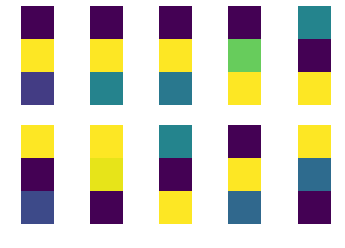

In [301]:
idxs = np.random.randint(0, Y.shape[0],10)#np.random.permutation(dgp.means)[:10]

# random_sample = dgp.means[idxs]

plt.figure()
for i, idx in enumerate(idxs,1):
#     rec= m.reconstruct(idx)
    rec = dgp_f.reconstruct(idx)
    plt.subplot(2,5,i)
#     print(rec.shape)
    plt.axis("off")
    plt.imshow(rec.flatten().reshape(28, 20))
plt.savefig("frey_3l_recon.png")
plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(y.flatten().reshape(28, 20))

plt.savefig("frey_orig_3l.png")
plt.figure()
for i, idx in enumerate(idxs, 1):
    plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(dgp_f.means[idx].flatten().reshape(3, 1))
plt.savefig("frey_3l_rep.png")

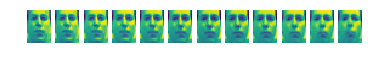

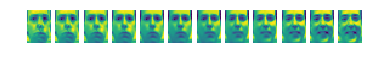

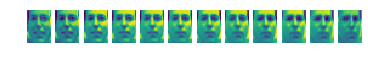

In [302]:
steps = np.arange(-3, 3, 0.5)
for i in range(3):
    plt.figure()
    for j, s in enumerate(steps):
        
        test = np.zeros((1,3))
        test[0][i] += s
        recon = dgp_f.reconstruct_from_input(test)
        plt.subplot(1, 12, j + 1 )
        plt.axis("off")
        plt.imshow(recon.reshape(28, 20))
        plt.savefig("frey_feature_{0}_trend_3l.png".format(i))
        

In [0]:
dgp2 = DeepGPLVM(kernel_dims = [10,5], n_layers = 2, max_iters=100, latent_dims = [10, 5], inducing_pts=[20, 20])
Y = subset.astype(np.float64)
dgp2.train(Y)
dgp2.reconstructon_error(Y)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -150863.756356
  Number of iterations: 100
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -150863.756356
  Number of iterations: 100
  Number of functions evaluations: 112


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3786.634038
  Number of iterations: 100
  Number of functions evaluations: 108


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3786.634038
  Number of iterations: 100
  Number of functions evaluations: 108


1.64509931828917

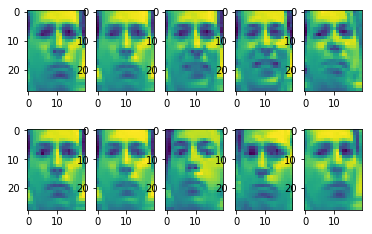

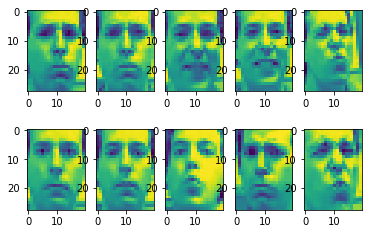

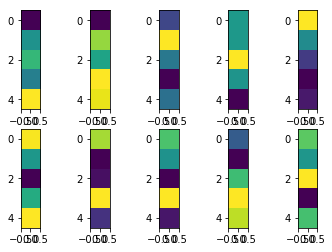

In [0]:
# random_sample = dgp.means[idxs]

plt.figure()
for i, idx in enumerate(idxs,1):
#     rec= m.reconstruct(idx)
    rec = dgp2.reconstruct(idx)
    plt.subplot(2,5,i)
#     print(rec.shape)
    plt.imshow(rec.flatten().reshape(28, 20))

plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.imshow(y.flatten().reshape(28, 20))

    
plt.figure()
for i, idx in enumerate(idxs, 1):
    plt.subplot(2,5,i)
    plt.imshow(dgp2.means[idx].flatten().reshape(5, 1))

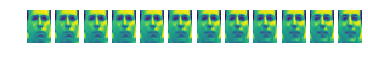

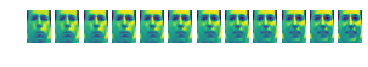

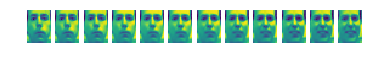

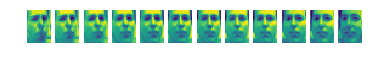

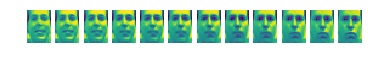

In [0]:
steps = np.arange(-3, 3, 0.5)
for i in range(5):
    plt.figure()
    for j, s in enumerate(steps):
        
        test = np.zeros((1,5))
        test[0][i] += s
        recon = dgp2.reconstruct_from_input(test)
        plt.subplot(1, 12, j + 1 )
        plt.axis("off")
        plt.imshow(recon.reshape(28, 20))

In [0]:
dgp2.means.min()

-2.8632264024270317

In [0]:
## variance explained for DGP means of each layer after pca
## to avoid overfitting and mode collapse --> explain

In [0]:
max_range = 100
num = int(0.8 * max_range)
trn_idxs = np.random.choice(range(max_range), num, replace=False)
test_idxs = np.array([i for i in range(max_range) if i not in trn_idxs])

In [0]:
from sklearn.svm import SVC
# def classifier_on_data(mnist_5_train, mnist_5_train_labels, mnist_5_test, mnist_5_test_labels, trn_idxs, test_idxs):
mnist_5_train = x_5[trn_idxs, :]
mnist_5_train_labels = l_5[trn_idxs]

mnist_5_test = x_5[test_idxs, :]
mnist_5_test_labels = l_5[test_idxs]

svc_mnist = SVC()
svc_mnist.fit(mnist_5_train, mnist_5_train_labels)
preds = svc_mnist.predict(mnist_5_test)

len(np.where(preds == mnist_5_test_labels)[0]) / len(preds)

In [0]:
# def classifier_on_data(mnist_5_train, mnist_5_train_labels, mnist_5_test, mnist_5_test_labels, trn_idxs, test_idxs):
XPCA = gpflow.models.PCA_reduce(Y, 5)
pca_train = XPCA[trn_idxs, :]
pca_test = XPCA[test_idxs, :]
svc_pca = SVC()
svc_pca.fit(pca_train, mnist_5_train_labels)
pca_preds = svc_pca.predict(pca_test)

len(np.where(pca_preds == mnist_5_test_labels)[0]) / len(pca_preds)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.75

In [0]:
means_5_train = dgp.means[trn_idxs, :]
means_5_test = dgp.means[test_idxs, :]
svc_rep = SVC()
svc_rep.fit(means_5_train, mnist_5_train_labels)
mean_preds = svc_rep.predict(means_5_test)

len(np.where(mean_preds == mnist_5_test_labels)[0]) / len(mean_preds)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.85

In [0]:
means_5_train_1l =GPLVM_X_mean[trn_idxs, :]
means_5_test_1l = GPLVM_X_mean[test_idxs, :]
svc_rep_1l = SVC()
svc_rep_1l.fit(means_5_train_1l, mnist_5_train_labels)
mean_preds_1l = svc_rep_1l.predict(means_5_test_1l)

len(np.where(mean_preds_1l == mnist_5_test_labels)[0]) / len(mean_preds_1l)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8

### Downstream classification accuracy comparison

In [0]:
def get_idxs(max_range = 100):
    num = int(0.8 * max_range)
    trn_idxs = np.random.choice(range(max_range), num, replace=False)
    test_idxs = np.array([i for i in range(max_range) if i not in trn_idxs])
    return trn_idxs, test_idxs

In [0]:
from sklearn.svm import SVC
def classifier_on_data(data, labels, trn_idxs, test_idxs):
    train_data = data[trn_idxs, :]
    train_labels = labels[trn_idxs]

    test_data = data[test_idxs, :]
    test_labels = labels[test_idxs]

    svc = SVC(gamma = "auto")
    svc.fit(train_data, train_labels)
    preds = svc.predict(test_data)

    return len(np.where(preds == test_labels)[0]) / len(preds)

In [259]:
XPCA = gpflow.models.PCA_reduce(Y, 5)
from tqdm import tqdm
results = []
for i in tqdm(range(500)):
    trn_idxs, test_idxs = get_idxs(x_5.shape[0])
    a1 = classifier_on_data(x_5, l_5, trn_idxs, test_idxs)
    a2 = classifier_on_data(XPCA, l_5, trn_idxs, test_idxs)
    a3 = classifier_on_data(GPLVM_X_mean, l_5, trn_idxs, test_idxs)
    a4 = classifier_on_data(dgp.means, l_5, trn_idxs, test_idxs)
    
    results.append([a1, a2, a3, a4])

results = np.array(results)

100%|██████████| 500/500 [00:08<00:00, 57.76it/s]


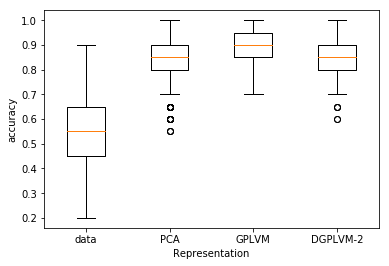

In [260]:
_ = plt.boxplot(results[:, :])
plt.xticks([1,2,3, 4], ['data', 'PCA', 'GPLVM', 'DGPLVM-2'])
plt.xlabel('Representation')
plt.ylabel('accuracy')
plt.savefig("boxplot_mnist.png")

In [0]:
from google.colab import files
files.download("frey_feature_2_trend_3l.png")

In [0]:
## Evaluations

## reconstruction error

## downstream classification (oilflow and MNIST subset)--> on unseen data 

## reconstruction_from_input --> new function --> takes test input

## what each feature is learning